# Rat RNN

### Load Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf

from unityagents import UnityEnvironment

%matplotlib inline

### Hyperparameters

In [2]:
learning_rate = 1e-4
l2_regularization = 0.1
hidden_units = 128
train_steps = 2000
ep_length = 400
sim_steps = 50000
batch_size = 8

model_path = 'rat_model'
data_path = 'rat_data'

## Generate Data
Prerequisite: Load unity project in the Editor. Build and save executable as "rat.exe" or "rat.app".

### Start Environment

In [ ]:
env_name = "rat" # Name of the Unity environment binary to launch
env = UnityEnvironment(file_name=env_name, worker_id=1)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]

### Collect States

In [ ]:
x,z,ep = [], [], []
input_x = []
a = env.reset()[default_brain]
for i in range(sim_steps - 1):
    
    # check for NANs
    if a.states[0].dtype != np.float64:
        print(i, a.states[0].dtype, a.states[0])
    elif np.any(np.isnan(a.states[0])):
        print(i, "NAN", a.states[0])
        
    # append
    x.append(a.states[0][0])
    z.append(a.states[0][1])
    input_x.append(a.states[0][2:-1])
    ep.append(a.states[0][-1])

    # next simulation step
    a = env.step()[default_brain]

    if i % (sim_steps/10) == 0 and i != 0:
        print(i)

In [ ]:
x = np.array(x)
z = np.array(z)
input_x = np.array(input_x)
input_y = np.stack((x, z), axis=1)

### Save Training Data

In [ ]:
if not os.path.exists(data_path):
    os.makedirs(data_path)

save_data = {"x": input_x, "y": input_y}
pickle.dump(save_data, open(data_path+"/data.p", "wb"))

## Load Training Data

In [17]:
save_data = pickle.load(open(data_path+"/data.p", "rb"))
input_x = save_data["x"]
input_y = save_data["y"]
x = input_y[:, 0]
z = input_y[:, 1]

### Visualize Rat Trajectory

In [4]:
def create_colors(length, segments):
    c_list = []
    for i in range(segments):
        color = np.zeros([length//segments, 4])
        color[:, 3] = 0.5
        color[:, 0:3] = np.random.uniform(0, 1, size=[1, 3])
        c_list.append(color)
    c_list = np.reshape(c_list, [length, 4])
    return c_list

(-4.5, 4.5)

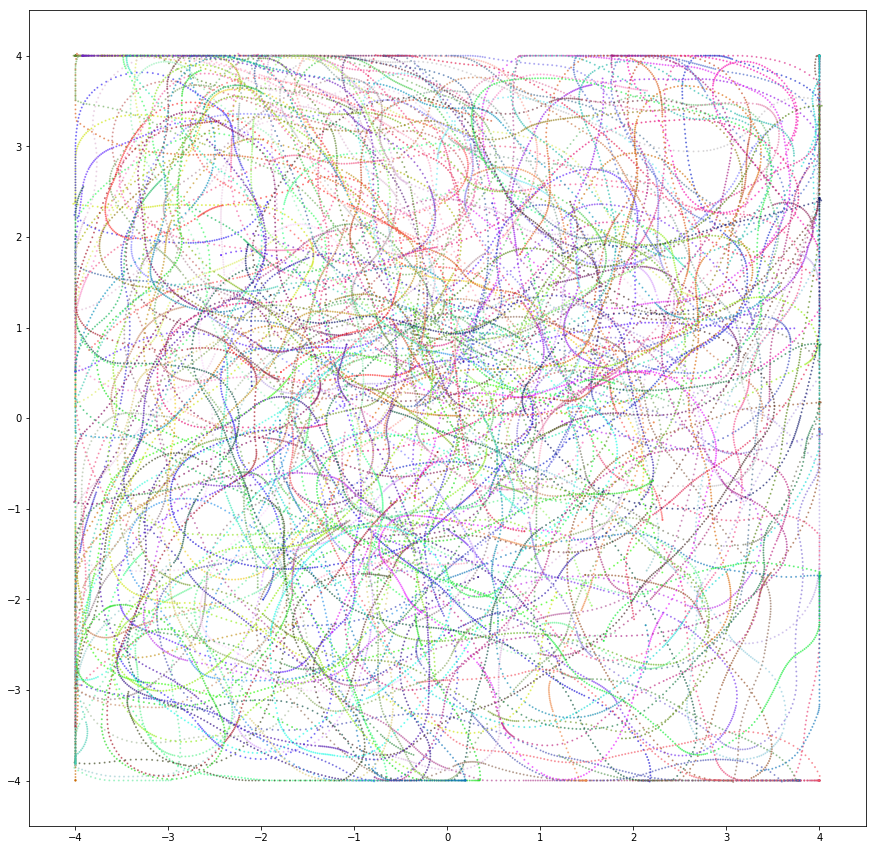

In [5]:
plt.figure(figsize=(15, 15))
plt.scatter(x, z, s=1, c=create_colors(sim_steps, sim_steps//ep_length))
plt.ylim(-4.5, 4.5)
plt.xlim(-4.5, 4.5)

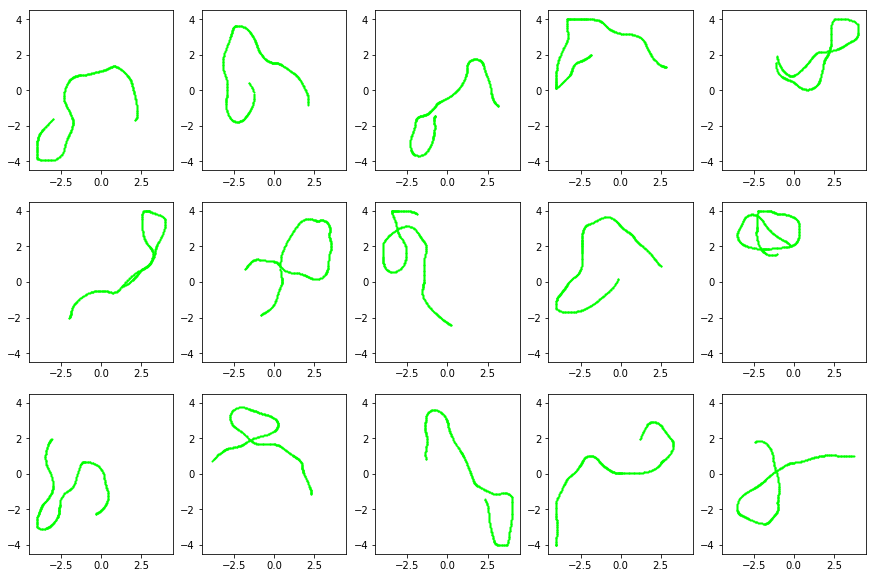

In [22]:
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.ylim(-4.5, 4.5)
    plt.xlim(-4.5, 4.5)
plt.show()

## Rat RNN

### Define Network

In [7]:
class RatRNN(object):
    def __init__(self, x_size, y_size, h_size, lr):
        self.x = tf.placeholder(shape=[None, x_size], dtype=tf.float32)
        self.train_length = tf.placeholder(shape=[1], dtype=tf.int32)
        self.batch_size = tf.placeholder(shape=[1], dtype=tf.int32)

        self.rnn_in = tf.reshape(self.x, shape=[self.batch_size[0], self.train_length[0], x_size])

        cell = tf.contrib.rnn.BasicLSTMCell(h_size, state_is_tuple=True)
        self.state_in = cell.zero_state(self.batch_size[0], tf.float32)

        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(inputs=self.rnn_in, cell=cell, dtype=tf.float32,
                                                     initial_state=self.state_in)

        self.output = tf.reshape(self.rnn, shape=[-1, h_size])
        
        self.y_pred = tf.layers.dense(self.output, y_size, activation=None)

        self.y = tf.placeholder(shape=[None, y_size], dtype=tf.float32)

        #l2_loss_a = tf.reduce_sum(tf.nn.l2_loss(tf.trainable_variables()[0]))
        #l2_loss_b = tf.reduce_sum(tf.nn.l2_loss(tf.trainable_variables()[1]))
        
        lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in tf.trainable_variables()
        #lossL2 = tf.add_n([ tf.reduce_sum(tf.abs(v)) for v in tf.trainable_variables()
                           if 'bias' not in v.name ]) * l2_regularization

        self.l2_loss = lossL2 # l2_loss_a + l2_loss_b
        self.regress_loss = tf.reduce_sum(tf.squared_difference(self.y, self.y_pred))
        self.loss = self.regress_loss + self.l2_loss

        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update = optimizer.minimize(self.loss)

In [8]:
tf.reset_default_graph()
rat_rnn = RatRNN(3, 2, hidden_units, learning_rate)
sess = tf.InteractiveSession()
saver = tf.train.Saver()

### Train Network

400 125.0


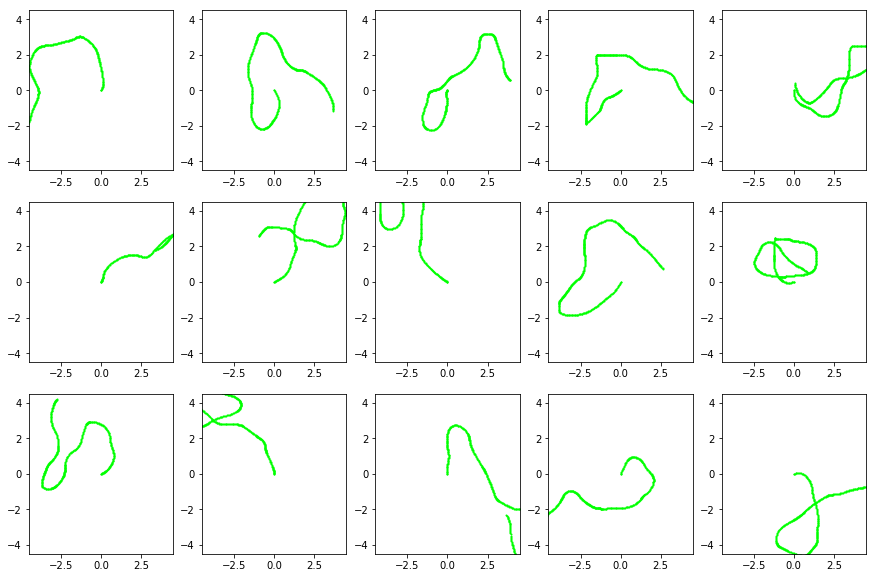

In [10]:
losses = []
init = tf.global_variables_initializer()
sess.run(init)
print(ep_length, sim_steps/ep_length)

# center training data
input_Y = np.copy(input_y)
for i in range(sim_steps//ep_length):
    pointer = i
    input_Y[pointer*ep_length:(pointer+1)*ep_length] -= input_Y[pointer*ep_length]

# debug viz
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_y = input_Y[pointer*ep_length:(pointer+1)*ep_length]
    
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.ylim(-4.5, 4.5)
    plt.xlim(-4.5, 4.5)
plt.show()

Loss: 34319.48828125 -- 1
Loss: 25592.345703125 -- 2
Loss: 23189.537109375 -- 3
Loss: 11672.9560546875 -- 4
Loss: 12586.7861328125 -- 5
Loss: 6331.13916015625 -- 6
Loss: 10094.060546875 -- 7
Loss: 14148.46875 -- 8
Loss: 9950.607421875 -- 9
Loss: 14254.564453125 -- 10
Loss: 9214.7939453125 -- 11
Loss: 11853.4677734375 -- 12
Loss: 9943.189453125 -- 13
Loss: 8092.71923828125 -- 14
Loss: 6347.265625 -- 15
Loss: 5168.91162109375 -- 16
Loss: 4609.2587890625 -- 17
Loss: 2453.985107421875 -- 18
Loss: 4526.38525390625 -- 19


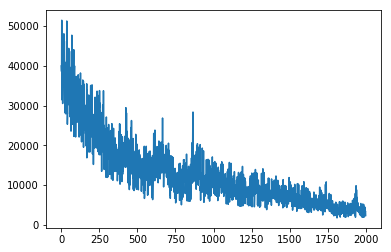

In [11]:
for i in range(train_steps):
    pointer = np.random.randint(0, sim_steps/ep_length - batch_size)
    batch_x = input_x[pointer*ep_length:(pointer+batch_size)*ep_length]
    batch_y = input_Y[pointer*ep_length:(pointer+batch_size)*ep_length]
    
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,3]), rat_rnn.y: np.reshape(batch_y, [-1, 2]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [batch_size]}
    loss, _ = sess.run([rat_rnn.loss, rat_rnn.update], feed_dict=feed_dict)
    if i % 100 == 0 and i != 0:
        print("Loss: {} -- {}".format(loss, i//100))
    losses.append(loss)
plt.plot(losses)

### Save Network Weights

In [12]:
if not os.path.exists(model_path):
    os.makedirs(model_path)

saver.save(sess, model_path + '/model.cptk')

'rat_model/model.cptk'

## Load Network Weights

In [13]:
ckpt = tf.train.get_checkpoint_state(model_path)
if ckpt == None:
  print('The model {0} could not be found. Make sure you specified the right '
    '--run-path'.format(model_path))
saver.restore(sess, ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from rat_model/model.cptk


INFO:tensorflow:Restoring parameters from rat_model/model.cptk


### Compare Trajectories

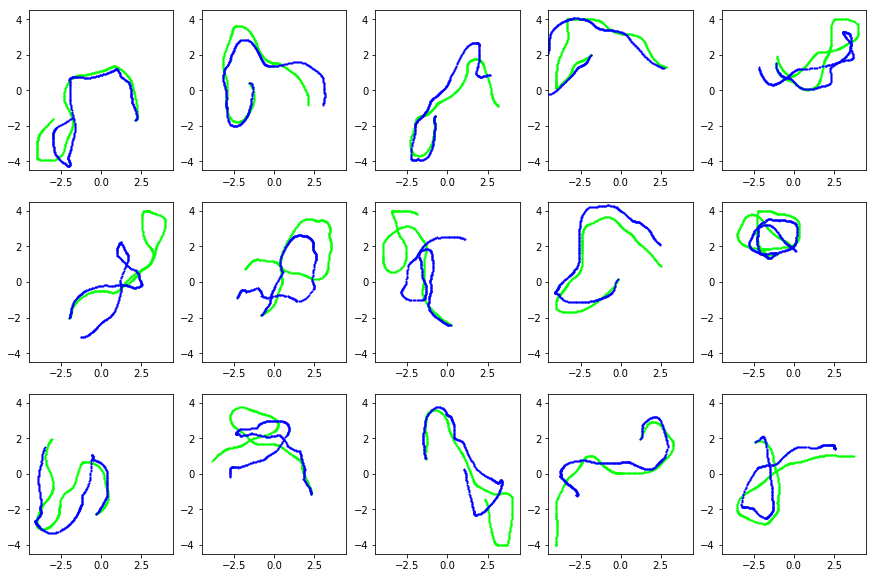

In [21]:
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_x = input_x[pointer*ep_length:(pointer+1)*ep_length]
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,3]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [1]}
    yp = sess.run(rat_rnn.y_pred, feed_dict=feed_dict) + batch_y[0]
    
    # Real - Green | Predicted - Blue
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.scatter(yp[:, 0], yp[:, 1], s=1, c=[0,0,1,1])
    plt.ylim(-4.5, 4.5)
    plt.xlim(-4.5, 4.5)
plt.show()

### Display neuron activation rates

In [19]:
resolution = 32
maze_extents = 4.5
rate = np.zeros([hidden_units, resolution, resolution])
for i in range(len(input_x)//ep_length):
    pointer = i
    batch_x = input_x[pointer*ep_length:(pointer+1)*ep_length]
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,3]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [1]}
    act = sess.run(rat_rnn.output, feed_dict=feed_dict)
    act = np.maximum(act, 0)
    
    for h in range(hidden_units):
        for j in range(ep_length):
            x = (batch_y[j][0] + maze_extents)/(maze_extents*2) * resolution
            y = (batch_y[j][1] + maze_extents)/(maze_extents*2) * resolution
            rate[h, int(x), int(y)] += act[j, h]

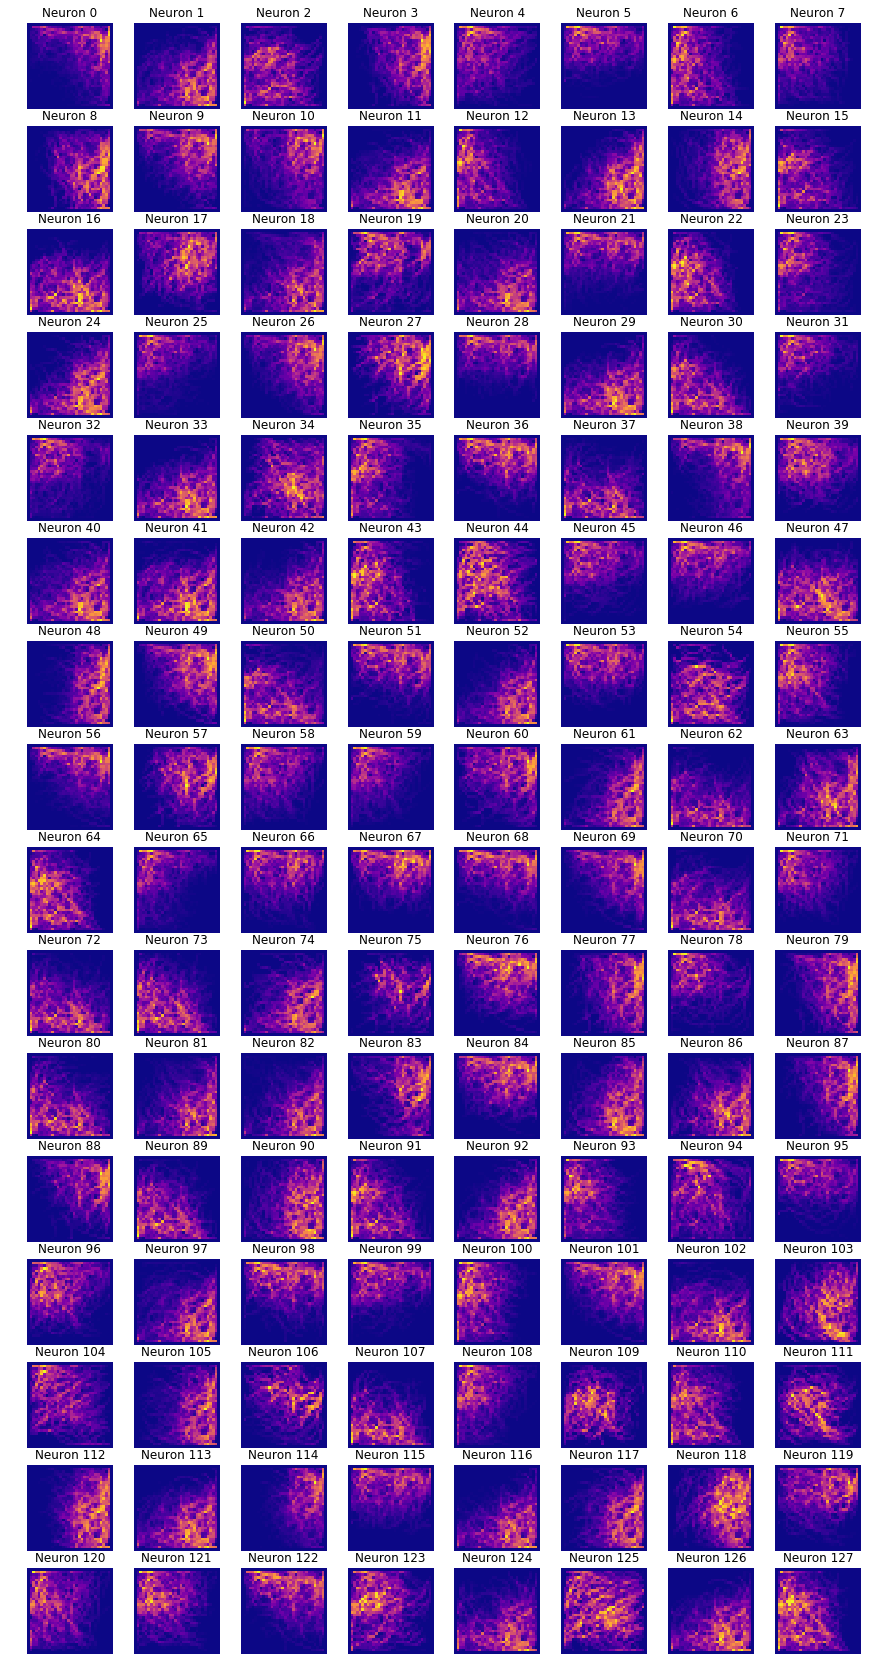

In [20]:
plt.figure(figsize=(15,30))
for h in range(hidden_units):
    plt.subplot(hidden_units//8, 8, 1 + h)
    plt.title('Neuron ' + str(h))
    plt.imshow(rate[h,:,:] / np.max(rate[h,:,:]), interpolation="nearest", cmap="plasma")
    plt.axis('off')
    
plt.show()

### Close TensorFlow Session & Environment

In [ ]:
sess.close()
env.close()

In [18]:
print(input_Y)
print(input_y)

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.01950339  0.03054468]
 ..., 
 [-0.50957108 -2.7690465 ]
 [-0.53803968 -2.7653836 ]
 [-0.56646156 -2.7613723 ]]
[[ 2.142549   -1.68252468]
 [ 2.142549   -1.68252468]
 [ 2.16205239 -1.65198   ]
 ..., 
 [-2.59664679 -0.7345707 ]
 [-2.62511539 -0.7309078 ]
 [-2.65353727 -0.7268965 ]]
